In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

1280 498


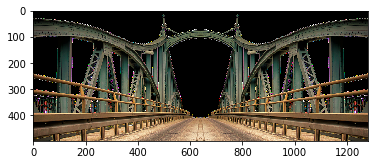

In [2]:
# reading image and it's parameter
OriImgC = cv2.imread('monument1.png')
OriImgC = cv2.cvtColor(OriImgC, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(OriImgC, cv2.COLOR_BGR2GRAY)
height = img.shape[0]
width = img.shape[1]
print(width,height)
plt.imshow(OriImgC.astype('uint8'),cmap='gray') 

In [3]:
def KeyPoints(windowSize,DOGImage1,DOGImage2,DOGImage3,ResizeC):
    offset = int(windowSize/2)
    
    h = DOGImage1.shape[0]
    w = DOGImage1.shape[1]
    
    points = []
    
    ################################
    
    Ix = np.zeros((DOGImage2.shape)) # generating gradient to apply shi-thomasi for removing unwanted homogenous keypoints
    Iy = np.zeros((DOGImage2.shape))

    for i in range(DOGImage2.shape[0]-1):
        for j in range(DOGImage2.shape[1]-1):
            Iy[i][j] = DOGImage2[i][j]-DOGImage2[i+1][j]
            Ix[i][j] = DOGImage2[i][j]-DOGImage2[i][j+1]
    Ixx = np.multiply(Ix,Ix)
    Iyy = np.multiply(Iy,Iy)
    Ixy = np.multiply(Iy,Ix)
    
    ################################
   
    for i in range(offset,h-offset):
        for j in range(offset,w-offset):
            I1 = DOGImage1[i-offset:i+offset+1,j-offset:j+offset+1]
            I2 = DOGImage2[i-offset:i+offset+1,j-offset:j+offset+1]
            I3 = DOGImage3[i-offset:i+offset+1,j-offset:j+offset+1]
            
            mid = I2[offset][offset]
            min1 = I1.min()
            min2 = I2.min()
            min3 = I3.min()
            
            minval = min(min1,min2,min3)           # calculating min value for neighbourhood
            
            flag=0
            
            if(mid <= minval):                     # checking if mid-pixel is local minima
                flag =1
                
            else:
                max1 = I1.max()
                max2 = I2.max()
                max3 = I3.max()
                
                maxval = max(max1,max2,max3)       # checking if mid-pixel is local maxima
                if(mid >= maxval):
                    flag=1

            if(flag==1):
                points.append((i,j))               # appending point if mid-pixel is local minima or local maxima
    
    k = 0.05
  
    off = 2
    shiVal = []
    for pt in points:
            x,y = pt
            Sumxx = np.sum(Ixx[x-off:x+off+1,y-off:y+off+1])                  # window size = 5
            Sumyy = np.sum(Iyy[x-off:x+off+1,y-off:y+off+1])
            Sumxy = np.sum(Ixy[x-off:x+off+1,y-off:y+off+1])

            M = np.array([[Sumxx,Sumxy],[Sumxy,Sumyy]])
            w,v = np.linalg.eig(M)
            shi = min(w)
            shiVal.append(shi)
            
    shimax = max(shiVal)
    for i in range(len(shiVal)):
            th = 0.6*shimax
            if(shiVal[i]>th):                          # giving clearance to key-point (removing homogeneous region false detected keypoints)
                x1,y1 = points[i]
                cv2.circle(ResizeC, (y1, x1),1, (255,255,0), 1) 
    
    return ResizeC
    

Scale 0:
Image Size :1280X498


/home/anuj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in ubyte_scalars
  app.launch_new_instance()
/home/anuj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


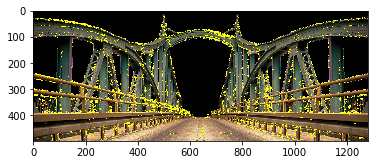

Scale 1:
Image Size :640X249


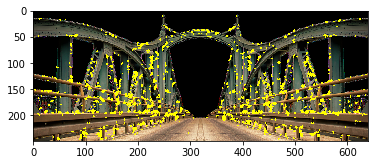

Scale 2:
Image Size :320X124


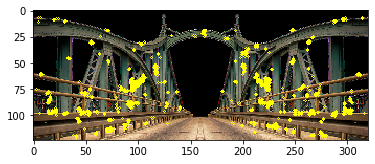

Scale 3:
Image Size :160X62


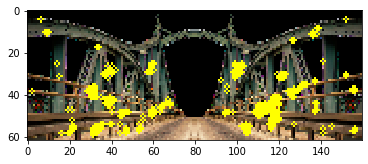

In [4]:
for i in range(4):                                    # 4 octaves # five blurr images # 4 DOG
    print("Scale "+str(i)+":")
    h = int(height/(2**i))       # reducing image size by half for each octave
    w = int(width/(2**i))
    print("Image Size :"+str(w)+"X"+str(h))
    ResizeC = cv2.resize(OriImgC, dsize=(w, h), interpolation=cv2.INTER_CUBIC)     # resize image
    ResizeG = cv2.cvtColor(ResizeC, cv2.COLOR_BGR2GRAY)
    
    root2 = 1.14
    sigma = 1.6*(i+1)
    
    Blur0 = cv2.GaussianBlur(ResizeG,(5,5),sigma,cv2.BORDER_DEFAULT) # applying 5 level of bluriness to each octave
    Blur1 = cv2.GaussianBlur(ResizeG,(5,5),sigma*root2,cv2.BORDER_DEFAULT)
    Blur2 = cv2.GaussianBlur(ResizeG,(5,5),sigma*root2**2,cv2.BORDER_DEFAULT)
    Blur3 = cv2.GaussianBlur(ResizeG,(5,5),sigma*root2**3,cv2.BORDER_DEFAULT)
    Blur4 = cv2.GaussianBlur(ResizeG,(5,5),sigma*root2**4,cv2.BORDER_DEFAULT)
    
    
    DOG0 = np.subtract(Blur0, Blur1) # getting DOG image by subtracting the consecutive blurred image
    DOG1 = np.subtract(Blur1, Blur2) 
    DOG2 = np.subtract(Blur2, Blur3) 
    DOG3 = np.subtract(Blur3, Blur4)
            
    windowSize = 9 - i*2
    ResizeC = KeyPoints(windowSize,DOG0,DOG1,DOG2,ResizeC)  # getting keypoints for Each tri-set of DOG
    ResizeC = KeyPoints(windowSize,DOG1,DOG2,DOG3,ResizeC)
    
    plt.imshow(ResizeC.astype('uint8'),cmap='gray')        # display final image for each octave
    plt.savefig("SIFT_octave"+str(i)+".png",format = "png", dpi = 300)
    plt.show()  